In [7]:
import re
import numpy as np
import sys
sys.path.insert(0, '../'); del sys
import pandas as pd
from tqdm import tqdm
import gc
import tensorflow as tf
tqdm.pandas()
import operator
import pickle
import time

from urllib.parse import unquote

In [8]:
from word_map import punc_mapping
from word_map import contraction_mapping
from word_map import mispell_dict
from word_map import special_punc_mappings
from word_map import spaces
from word_map import rare_words_mapping
from word_map import extra_punct
from word_map import bad_case_words

In [9]:
MINCOUNT = 14

In [10]:
# remove space
def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

# replace strange punctuations and raplace diacritics
from unicodedata import category, name, normalize

def remove_diacritics(s):
    return ''.join(c for c in normalize('NFKD', s.replace('ø', 'o').replace('Ø', 'O').replace('⁻', '-').replace('₋', '-'))
                  if category(c) != 'Mn')

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    # 注意顺序，remove_diacritics放前面会导致 'don´t' 被处理为 'don t'
    #text = remove_diacritics(text)
    return text

# clean numbers
def clean_number(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    text = re.sub(r'(\d+)(e)(\d+)',r'\1 \3', text)
    
    #num = re.compile(r'\s((\$)?\d+(,)?\d*)+')
    num = re.compile(r'((\$)?\d+(,)?\d*)+')
    text = re.sub(num, ' NUMBER ', text)
    return text

# JINKI
def clean_money(text):
    num = re.compile(r'\s((\$)?\d+(,)?\d*)+\s')
    text = re.sub(num, ' NUMBER ', text)
    return text

def pre_clean_rare_words(text):
    for rare_word in rare_words_mapping:
        if rare_word in text:
            text = text.replace(rare_word, rare_words_mapping[rare_word])

    return text

def clean_misspell(text):
    for bad_word in mispell_dict:
        if bad_word in text:
            text = text.replace(bad_word, mispell_dict[bad_word])
    return text

import string
regular_punct = list(string.punctuation)
all_punct = list(set(regular_punct + extra_punct))
# do not spacing - and .
all_punct.remove('-')
all_punct.remove('.')

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, ' ' + punc + ' ')
    return text

def clean_bad_case_words(text):
    for bad_word in bad_case_words:
        if bad_word in text:
            text = text.replace(bad_word, bad_case_words[bad_word])
    return text

mis_connect_list = ['(W|w)hat', '(W|w)hy', '(H|h)ow', '(W|w)hich', '(W|w)here', '(W|w)ill']
mis_connect_re = re.compile('(%s)' % '|'.join(mis_connect_list))

mis_spell_mapping = {'whattsup': 'WhatsApp', 'whatasapp':'WhatsApp', 'whatsupp':'WhatsApp', 
                      'whatcus':'what cause', 'arewhatsapp': 'are WhatsApp', 'Hwhat':'what',
                      'Whwhat': 'What', 'whatshapp':'WhatsApp', 'howhat':'how that',
                      'Whybis':'Why is', 'laowhy86':'Foreigners who do not respect China',
                      'Whyco-education':'Why co-education',
                      "Howddo":"How do", 'Howeber':'However', 'Showh':'Show',
                      "Willowmagic":'Willow magic', 'WillsEye':'Will Eye', 'Williby':'will by'}

def spacing_some_connect_words(text):
    """
    'Whyare' -> 'Why are'
    """
    ori = text
    for error in mis_spell_mapping:
        if error in text:
            text = text.replace(error, mis_spell_mapping[error])

    text = re.sub(r" (W|w)hat+(s)*[A|a]*(p)+ ", " WhatsApp ", text)
    text = re.sub(r" (W|w)hat\S ", " What ", text)
    text = re.sub(r" \S(W|w)hat ", " What ", text)
    text = re.sub(r" (W|w)hy\S ", " Why ", text)
    text = re.sub(r" \S(W|w)hy ", " Why ", text)
    text = re.sub(r" (H|h)ow\S ", " How ", text)
    text = re.sub(r" \S(H|h)ow ", " How ", text)
    text = re.sub(r" (W|w)hich\S ", " Which ", text)
    text = re.sub(r" \S(W|w)hich ", " Which ", text)
    text = re.sub(r" (W|w)here\S ", " Where ", text)
    text = re.sub(r" \S(W|w)here ", " Where ", text)
    #text = mis_connect_re.sub(r" \1 ", text)
    text = text.replace("What sApp", 'WhatsApp')
    
    text = remove_space(text)
    return text

# clean repeated letters
def clean_repeat_words(text):
    
    text = re.sub(r"(I|i)(I|i)+ng", "ing", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+y", "lly", text)
    text = re.sub(r"(A|a)(A|a)(A|a)+", "a", text)
    text = re.sub(r"(C|c)(C|c)(C|c)+", "cc", text)
    text = re.sub(r"(D|d)(D|d)(D|d)+", "dd", text)
    text = re.sub(r"(E|e)(E|e)(E|e)+", "ee", text)
    text = re.sub(r"(F|f)(F|f)(F|f)+", "ff", text)
    text = re.sub(r"(G|g)(G|g)(G|g)+", "gg", text)
    text = re.sub(r"(I|i)(I|i)(I|i)+", "i", text)
    text = re.sub(r"(K|k)(K|k)(K|k)+", "k", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+", "ll", text)
    text = re.sub(r"(M|m)(M|m)(M|m)+", "mm", text)
    text = re.sub(r"(N|n)(N|n)(N|n)+", "nn", text)
    text = re.sub(r"(O|o)(O|o)(O|o)+", "oo", text)
    text = re.sub(r"(P|p)(P|p)(P|p)+", "pp", text)
    text = re.sub(r"(Q|q)(Q|q)+", "q", text)
    text = re.sub(r"(R|r)(R|r)(R|r)+", "rr", text)
    text = re.sub(r"(S|s)(S|s)(S|s)+", "ss", text)
    text = re.sub(r"(T|t)(T|t)(T|t)+", "tt", text)
    text = re.sub(r"(V|v)(V|v)+", "v", text)
    text = re.sub(r"(Y|y)(Y|y)(Y|y)+", "y", text)
    text = re.sub(r"plzz+", "please", text)
    text = re.sub(r"(Z|z)(Z|z)(Z|z)+", "zz", text)
    text = re.sub(r"(-+|\.+)", " ", text)
    
    # JINKI
    text = re.sub(r"(\!)+", "!", text)
    text = re.sub(r"(\@)+", "", text)
    text = re.sub(r"(\#)+", "", text)
    text = re.sub(r"(\$)+", "", text)
    text = re.sub(r"(\%)+", "", text)
    text = re.sub(r"(\^)+", "", text)
    text = re.sub(r"(\&)+", "", text)
    text = re.sub(r"(\*)+", "", text)
    text = re.sub(r"(\+)+", "", text)
    text = re.sub(r"(\=)+", "", text)
    text = re.sub(r"(\_)+", "_", text)
    text = re.sub(r"(\<)+", ">", text)
    text = re.sub(r"(\>)+", ">", text)
    text = re.sub(r"(\?)+", "?", text)
    text = re.sub(r"(\.)+", ".", text)
    text = re.sub(r"(\:)+", "", text)
    text = re.sub(r"(\/)+", "", text)
    
    return text

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

def correct_spelling(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

def remove_url(text):
    pat = re.compile(r'(https://|http://|http//)(\w|\.|\/|\-|\?|\=|\&|\+|\#|\%)+')
    text = re.sub(pat, ' URL ', text)
    return text

def preprocess(text):
    """http://172.30.1.100:9999/notebooks/ipynb/text%20cleaning.ipynb#
    preprocess text main steps
    """
    text = unquote(text)
    text = remove_space(text)
    text = clean_special_punctuations(text)
    text = clean_number(text)
    text = pre_clean_rare_words(text)
    text = clean_misspell(text)
    #text = spacing_punctuation(text)
    text = spacing_some_connect_words(text)
    text = clean_bad_case_words(text)
    text = remove_url(text)
    text = clean_repeat_words(text)
    text = remove_space(text)
    
    # JINKI
    text = text.lower()
    text = re.sub(r"\'", " QUOTE ", text)
    
    # my own cleaning
    #text = clean_money(text)
    
    return text

def text_clean_wrapper(df):
    df["comment_text"] = df["comment_text"].apply(preprocess)
    return df

In [11]:
from multiprocessing import Pool
import psutil
num_partitions = 20 # number of partitions to split dataframe
num_cores = psutil.cpu_count()  # number of cores on your machine

def df_parallelize_run(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    #df = sp.vstack(pool.map(func, df_split), format='csr') faster and mem efficient for
    pool.close()
    pool.join()
    
    return df

In [12]:
def clean_comment_text(df):
    df = df_parallelize_run(df, text_clean_wrapper)
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: correct_contraction(x, punc_mapping))
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: clean_number(x))
    
    #del contraction_mapping
    gc.collect()
    
    return df

In [13]:
#train = pd.read_csv('/data/jigsaw/train_sample.csv')
train = pd.read_csv('/data/jigsaw/train.csv.zip', compression='zip')
#test = pd.read_csv('/data/jigsaw/test.csv')
#test = df_parallelize_run(test, text_clean_wrapper)

In [8]:
%%time
train = df_parallelize_run(train, text_clean_wrapper)

CPU times: user 3.03 s, sys: 3.54 s, total: 6.57 s
Wall time: 8min 45s


In [9]:
train['comment_text'] = train['comment_text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
train['comment_text'] = train['comment_text'].progress_apply(lambda x: correct_contraction(x, punc_mapping))
train['comment_text'] = train['comment_text'].progress_apply(lambda x: clean_number(x))

100%|██████████| 1804874/1804874 [01:44<00:00, 17309.98it/s]


In [10]:
word_cnt = {}
for text in train['comment_text']:
    text = text.split()
    for t in text:
        try:
            word_cnt[t] += 1
        except KeyError:
            word_cnt[t] = 1

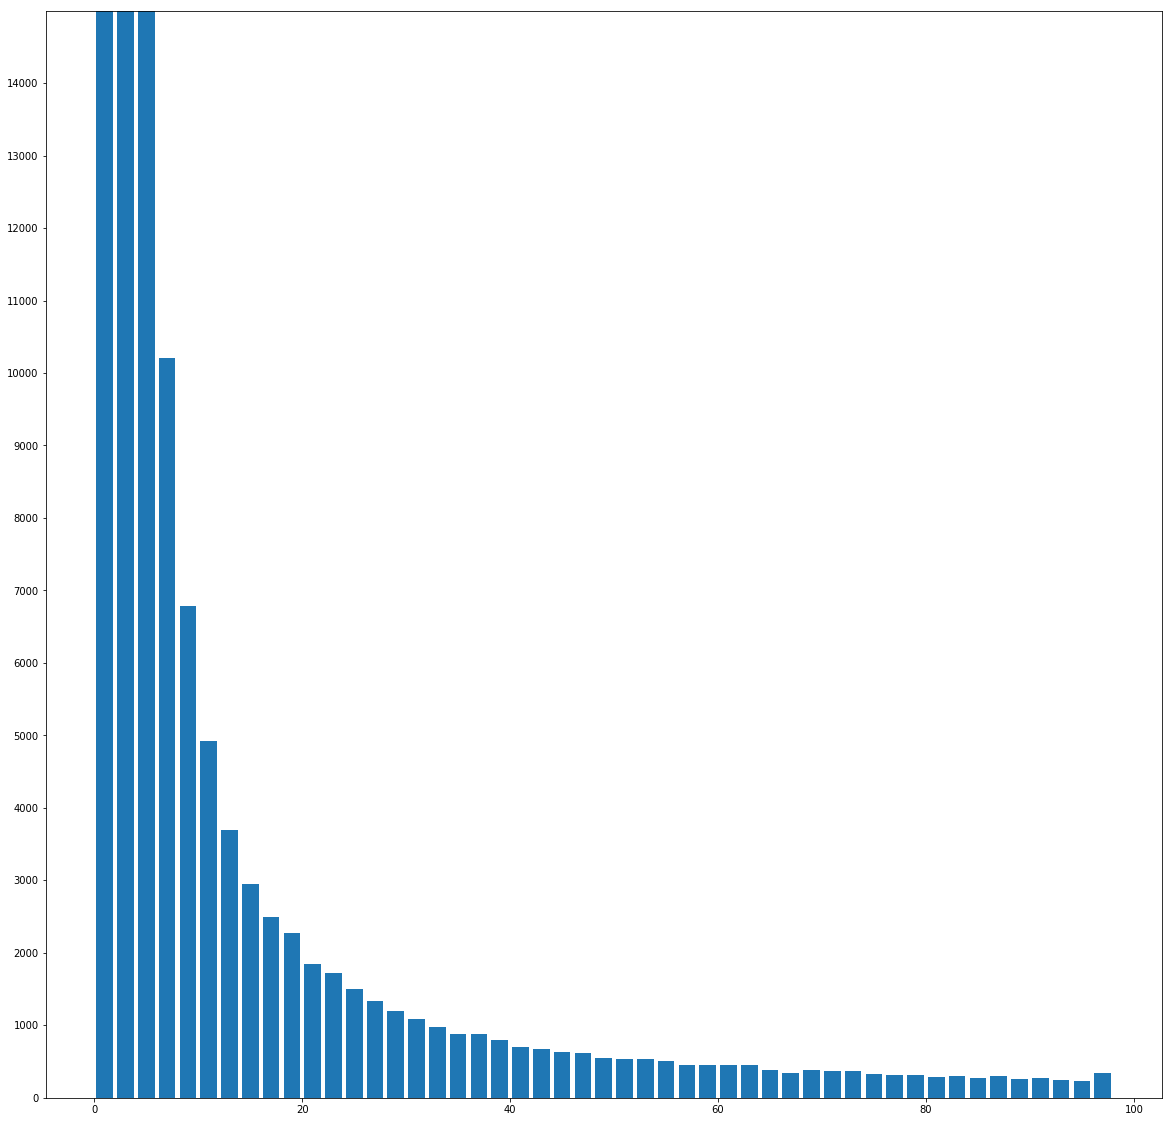

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.hist(word_cnt.values(), bins=np.arange(0, 100, 2), rwidth=0.8)
plt.ylim(0, 15000)
plt.yticks(np.arange(0, 15000, 1000))
plt.show()

In [12]:
sorted_word_cnt = sorted(word_cnt.items(), key=operator.itemgetter(0))
word_list = [k for k,v in sorted_word_cnt if v >= MINCOUNT]
#word_dict = [for i, w in enumerate(word_list)]

In [13]:
filtered_word = ['PAD'] + [w[0] for w in list(filter(lambda x: x[1] > MINCOUNT, sorted_word_cnt))]

In [14]:
filtered_word.append('UNKNOWN')

In [15]:
time_hash = hash(time.time())
word_pickle_filename = 'word_{}_{}.pkl'.format(MINCOUNT, time_hash)
pickle.dump(filtered_word, open(word_pickle_filename,'wb'))

In [17]:
len(filtered_word)

53449

In [20]:
word_pickle_filename

'word_14_665013221336055259.pkl'

# 1. Feature Engineering

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle
word = pickle.load(open('word_14_665013221336055259.pkl','rb'))

In [3]:
word_dict = {w:i for i, w in enumerate(word)}
#word_dict['UNKNOWN'] = len(word_dict)

In [4]:
word_dict['PAD']

0

In [22]:
#train = pd.read_csv('/data/jigsaw/train_sample.csv')
#train = pd.read_csv('/data/jigsaw/train.csv.zip', compression='zip')
train = pd.read_csv('/data/jigsaw/test.csv.zip', compression='zip')

In [23]:
%%time
train = clean_comment_text(train)

100%|██████████| 97320/97320 [00:05<00:00, 17578.73it/s]

CPU times: user 14.3 s, sys: 261 ms, total: 14.5 s
Wall time: 40.1 s


In [24]:
def tokenize_text(text):
    text = text.split(' ')
    word_index = np.zeros(len(text), dtype=np.int32)
    for i, t in enumerate(text):
        try:
            word_index[i] = word_dict[t]
        except KeyError:
            word_index[i] = word_dict['UNKNOWN']
    return word_index

In [25]:
%%time
train.loc[:,'vectorized'] = train['comment_text'].progress_apply(lambda x: tokenize_text(x))

100%|██████████| 97320/97320 [00:01<00:00, 61048.33it/s]

CPU times: user 1.6 s, sys: 12 ms, total: 1.61 s
Wall time: 1.61 s


In [26]:
train.loc[:,'vector_length'] = train.vectorized.apply(len)

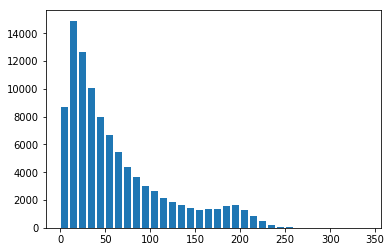

In [27]:
import matplotlib.pyplot as plt
_ = plt.hist(train.vector_length, bins=np.arange(0, 350, 10), rwidth=0.8)

In [28]:
train.vector_length.max()

362

In [29]:
(train.vector_length > 250).mean()

0.00041101520756267981

In [30]:
pickle.dump(train.vectorized.values, open('vectorized.pkl', 'wb'))

In [ ]:
train.shape

### 1.2 count UNKNOWN words

In [ ]:
def count_unknown(text):
    return np.where(np.array(text) == word_dict['UNKNOWN'], True, False).sum()/len(text)

In [ ]:
#train.loc[:'unknown_count'] = train.vectorized.apply(lambda x: np.where(x == word_dict['UNKNOWN'], True, False).sum())
train.loc[:,'unknown_count'] = train.vectorized.apply(count_unknown)

In [ ]:
_ = plt.hist(train.unknown_count, bins=np.arange(0, 1.0, 0.1), rwidth=0.8)

In [ ]:
(train.unknown_count < 0.3).sum()/train.shape[0]

In [ ]:
train.unknown_count.max()